<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/mmdet_custom_config
.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMDetection Custom Config

when creating an MMDetection `model`, the model `config` object is stored in `model.cfg` and the pretrained weight file path is stored in `model.weights_path`. In order to update model config attribute, you might use of the 2 following options: 


**Example: Changing loss weights for loss_bbox and loss_cls**

## Option 1: Before creating a model using a config file
You can pass the `cfg_options` argument when creation a model

  ```python
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  'cfg_options' = { 
    'model.bbox_head.loss_bbox.loss_weight': 2,
    'model.bbox_head.loss_cls.loss_weight': 0.8 }

  # Passing cfg_options to the `model()` method to update loss weights
  model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), cfg_options=cfg_options)
  ``` 

## Option 2: After creating a model
First create an MMDetection model, and access all the module attributes using the `model.cfg` object
  ```python
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

  # We don't use cfg_options 
  model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map))

  # Update loss weights
  model.bbox_head.loss_bbox.loss_weight = 2
  model.bbox_head.loss_cls.loss_weight = 0.8
  ```

## Install IceVision and IceData
The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, and Yolo v5 as well
as the fastai and pytorch lightning engines.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

## Imports
All of the IceVision components can be easily imported with a single line.


In [ ]:
from icevision.all import *

## Download and prepare a dataset
Now we can start by downloading the Fridge Objects dataset. This tiny dataset contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides methods to load a dataset, parse annotation files, and more.

For more information about how the fridge dataset as well as its corresponding parser, check out the [fridge folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/fridge) in icedata.

In [3]:
# Download the dataset
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

## Parse the dataset


In [4]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")

In [ ]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

## Creating datasets with agumentations and transforms

In [6]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [6]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

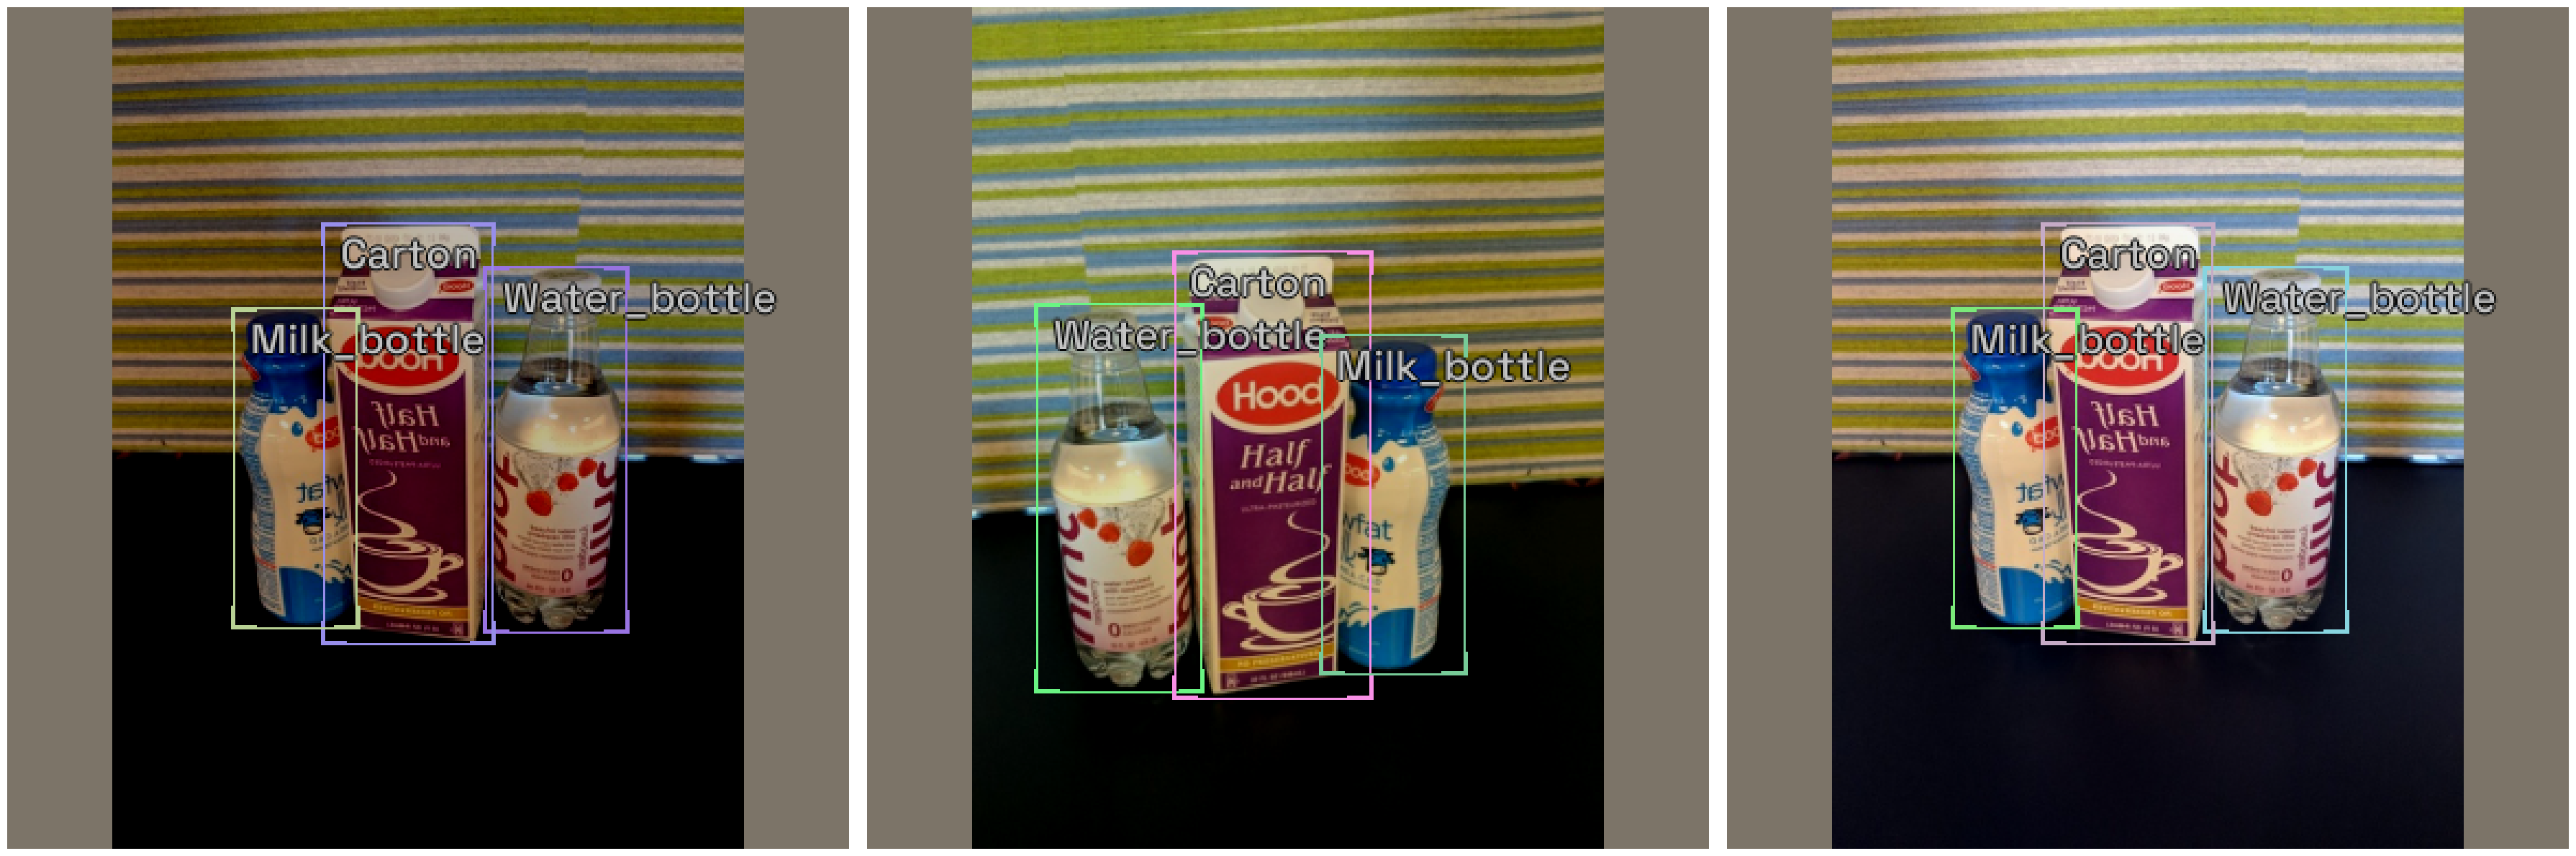

In [7]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Creating a model
This shows how to customize a retinanet model by using the `cfg_options` object:
```
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True, cfg_options=cfg_options)
```
As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how to easily customize your model.


## Option 1: 

In [11]:
# Just the config options you would like to update

selection = 0


extra_args = {}

# Example: Changing both loss weights: loss_bbox, loss_cls
if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  cfg_options = { 
    'model.bbox_head.loss_bbox.loss_weight': 2,
    'model.bbox_head.loss_cls.loss_weight': 0.8,
     }

# Example: cahnging anchor boxes ratios:
elif selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  cfg_options = { 
    'model.bbox_head.anchor_generator.ratios': [1.0] 
    }


cfg_options

{'model.bbox_head.loss_bbox.loss_weight': 2,
 'model.bbox_head.loss_cls.loss_weight': 0.8}


Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [12]:
# Instantiate the model and pass the `cfg_options` dictionary
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), cfg_options=cfg_options) 

Merging cfg_options: {'model.bbox_head.loss_bbox.loss_weight': 2, 'model.bbox_head.loss_cls.loss_weight': 0.8}


/home/farid/anaconda3/envs/icevision/lib/python3.8/site-packages/mmcv/cnn/utils/weight_init.py:99: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  warnings.warn(


Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([36, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([36]).


In [15]:
print(model.bbox_head.loss_bbox.loss_weight)
print(model.bbox_head.loss_cls.loss_weight)
print(model.bbox_head.anchor_generator.ratios)

2
0.8
tensor([0.50000, 1.00000, 2.00000])


In [13]:
print(model.cfg.model.bbox_head.loss_cls.loss_weight)
print(model.cfg.model.bbox_head.loss_bbox.loss_weight)
print(model.cfg.model.bbox_head.anchor_generator.ratios)

0.8
2
[0.5, 1.0, 2.0]


## Option 2: 

In [16]:
# Instantiate the model without passing any `cfg_options` dictionary
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([36, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([36]).


In [40]:
print(model.bbox_head.loss_bbox.loss_weight)
print(model.bbox_head.loss_cls.loss_weight)
print(model.bbox_head.anchor_generator.ratios)

1.0
1.0


In [41]:
# Update loss weights using the `model.cfg` object
model.bbox_head.loss_bbox.loss_weight = 2
model.bbox_head.loss_cls.loss_weight = 0.8
model.bbox_head.anchor_generator.ratios = [1]

In [42]:
print(model.bbox_head.loss_bbox.loss_weight)
print(model.bbox_head.loss_cls.loss_weight)
print(model.bbox_head.anchor_generator.ratios)

2
0.8
[1]


In [43]:
# Optional: update `model.cfg` to sync cfg attributes with those of the model
model.cfg.model.bbox_head.loss_bbox.loss_weight = 2
model.cfg.model.bbox_head.loss_cls.loss_weight = 0.8
model.cfg.model.bbox_head.anchor_generator.ratios = [1]

In [44]:
print(model.cfg.model.bbox_head.loss_cls.loss_weight)
print(model.cfg.model.bbox_head.loss_bbox.loss_weight)
print(model.cfg.model.bbox_head.anchor_generator.ratios)

0.8
2
[1]


## Print new config settings

In [45]:
# You have access to model's weights_path
model.weights_path

Path('checkpoints/retinanet/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth')

In [46]:
# Double checking model attributes `loss_cls`
model.cfg.model.bbox_head.loss_cls

{'type': 'FocalLoss',
 'use_sigmoid': True,
 'gamma': 2.0,
 'alpha': 0.25,
 'loss_weight': 0.8}

In [47]:
# Double checking model attributes `anchor_generator`
model.cfg.model.bbox_head.anchor_generator

{'type': 'AnchorGenerator',
 'octave_base_scale': 4,
 'scales_per_octave': 3,
 'ratios': [1],
 'strides': [8, 16, 32, 64, 128]}

## Data Loader

The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [16]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

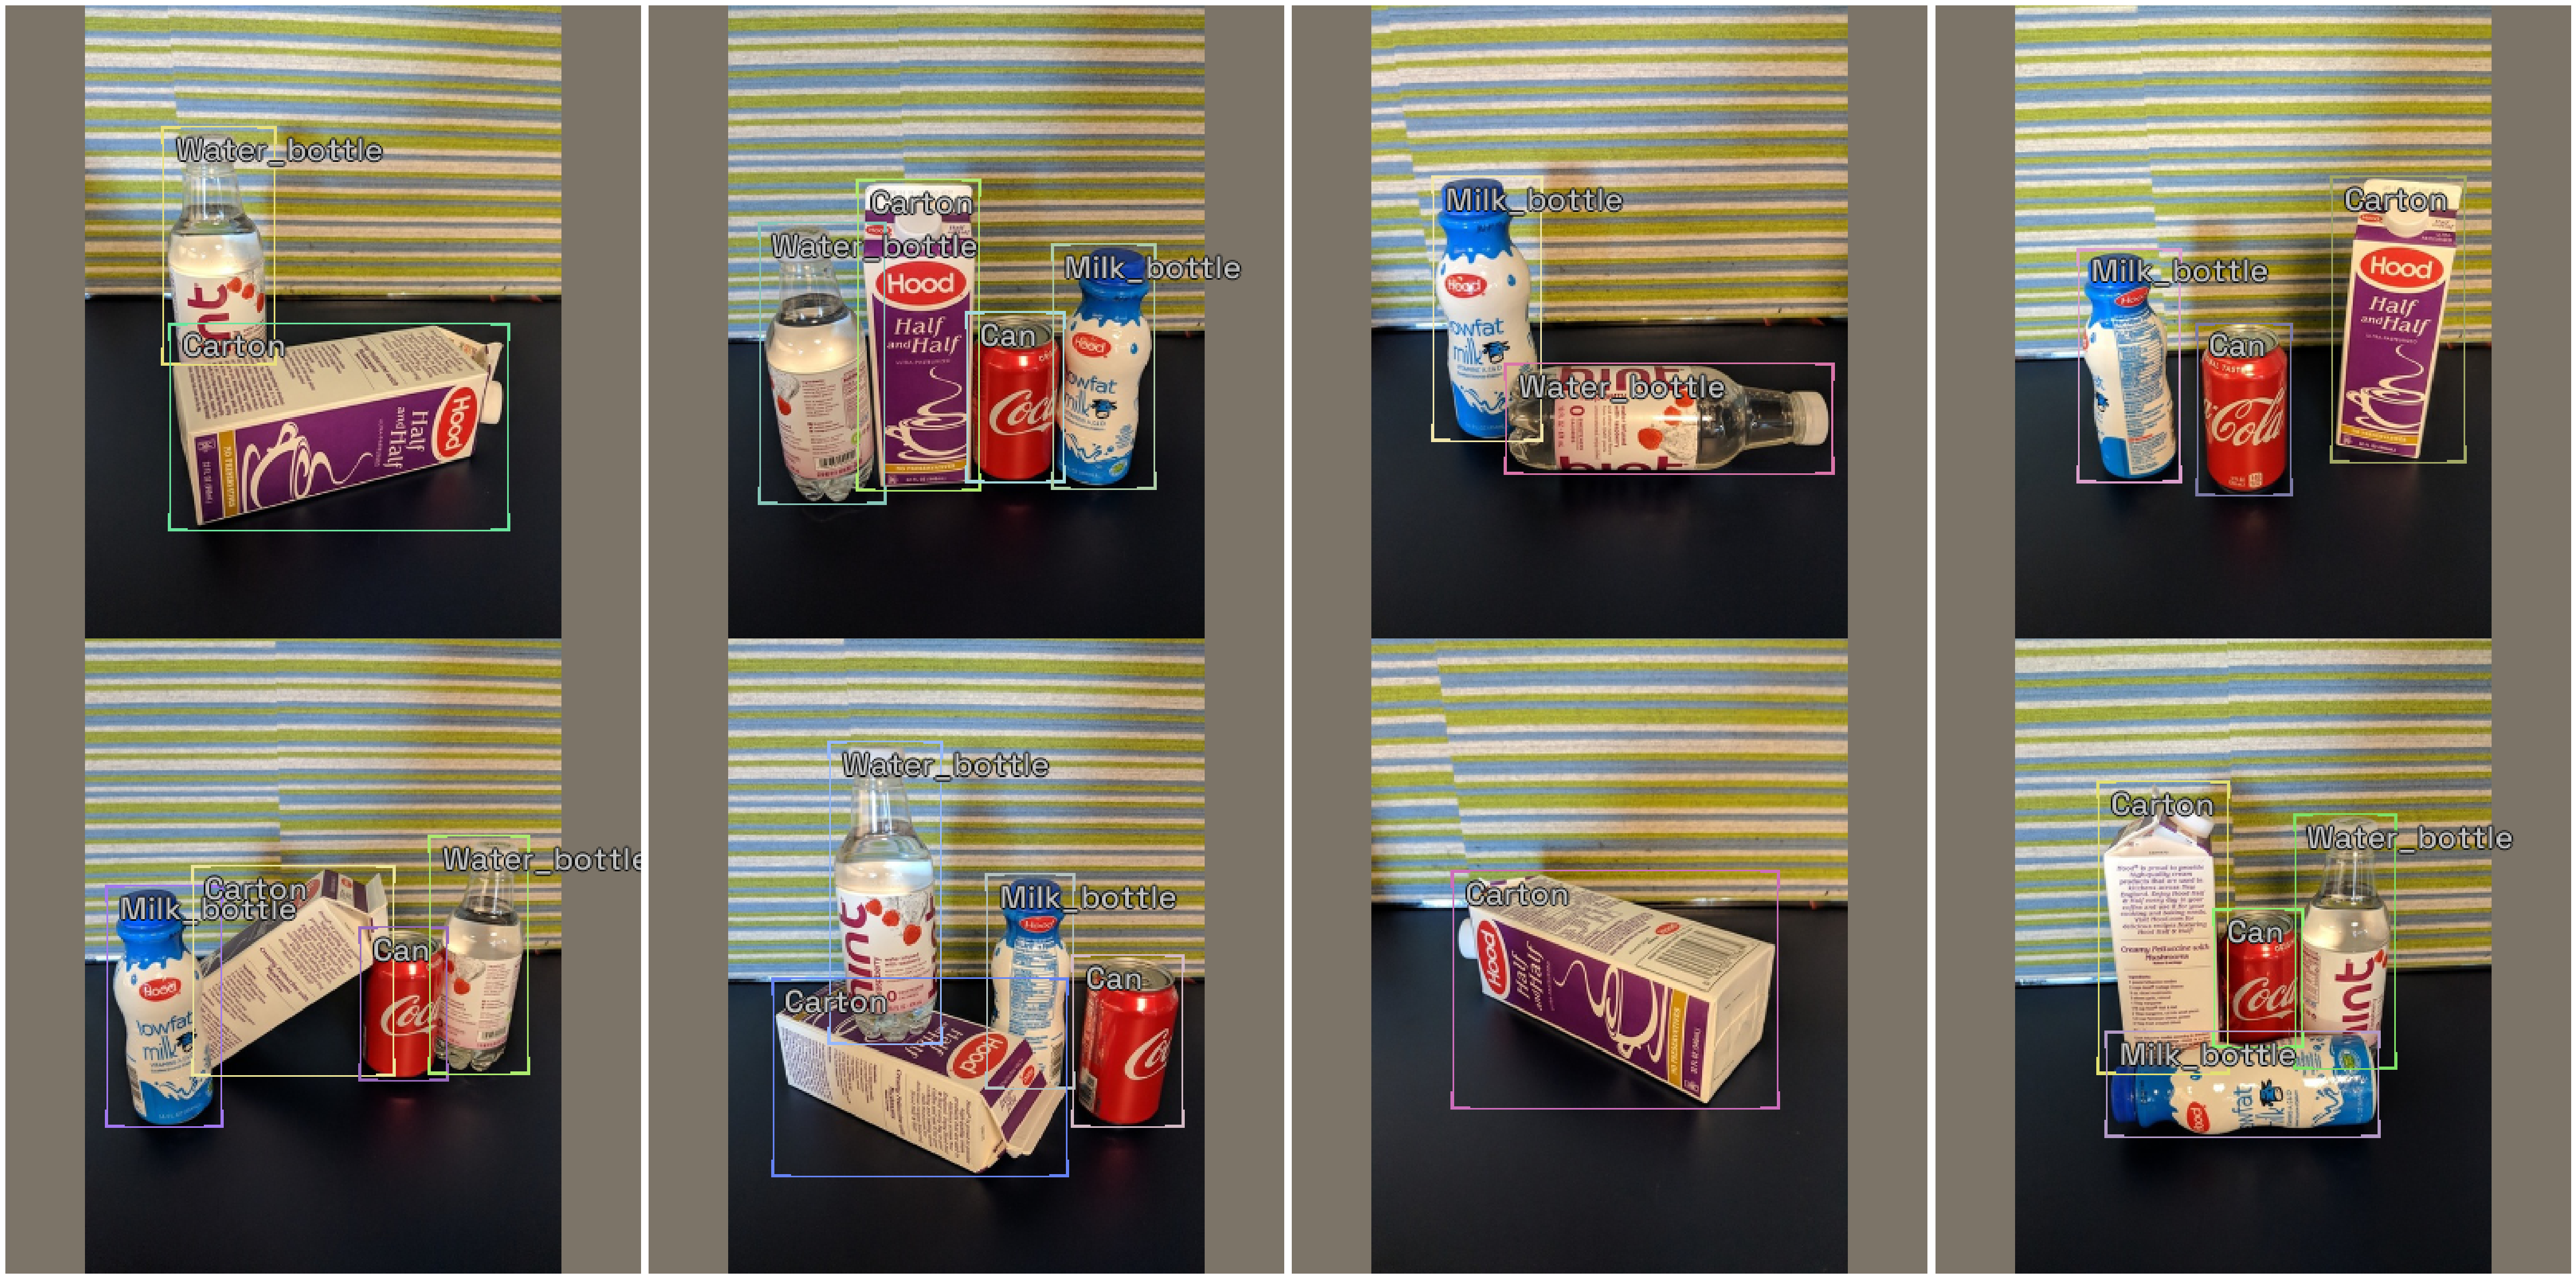

In [17]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

In [18]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  


### Training using fastai

In [19]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=9.120108734350652e-05)

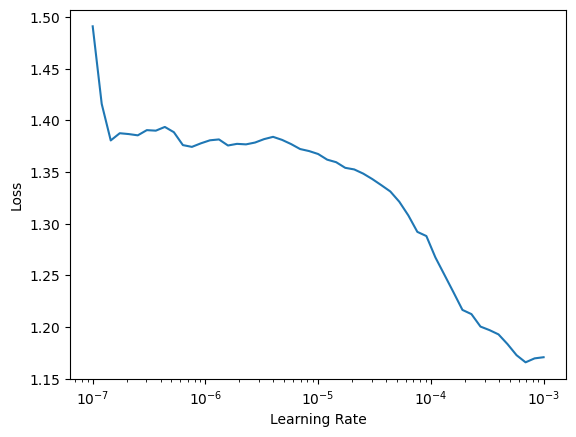

In [17]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [20]:
learn.fine_tune(1, 1e-4, freeze_epochs=1)

### Training using Pytorch Lightning

In [23]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=20, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

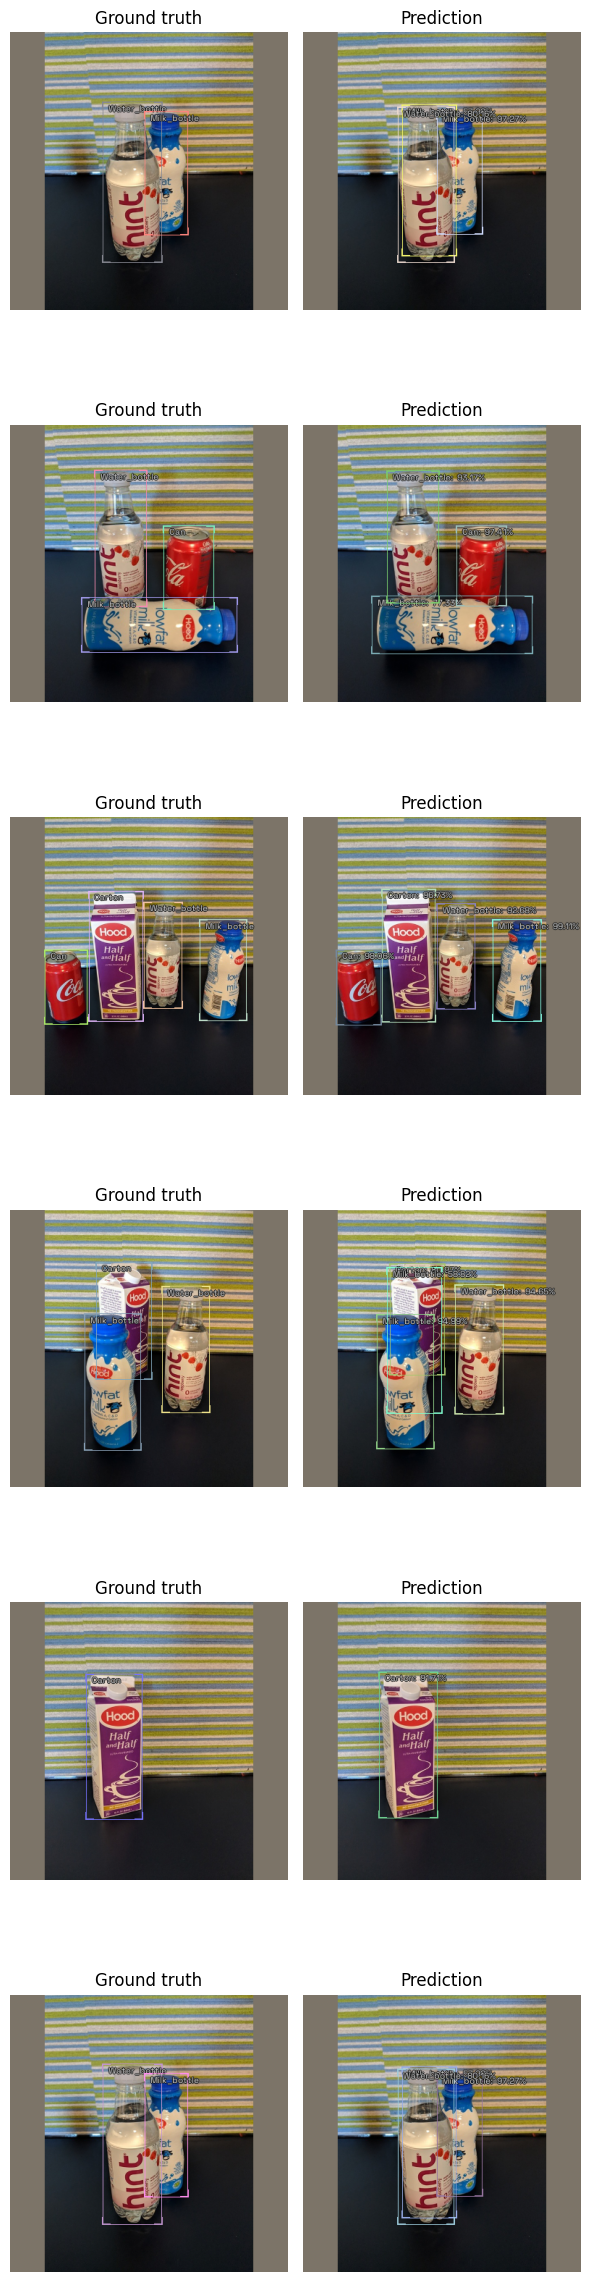

In [20]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

### Prediction

Sometimes you want to have more control than `show_results` provides. You can construct an inference dataloader using `infer_dl` from any IceVision dataset and pass this to `predict_dl` and use `show_preds` to look at the predictions.

A prediction is returned as a dict with keys: `scores`, `labels`, `bboxes`, and possibly `masks`. 

Prediction functions that take a `detection_threshold` argument will only return the predictions whose score is above the threshold.

Prediction functions that take a `keep_images` argument will only return the (tensor representation of the) image when it is `True`. In interactive environments, such as a notebook, it is helpful to see the image with bounding boxes and labels applied. In a deployment context, however, it is typically more useful (and efficient) to return the bounding boxes by themselves.



> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [1]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

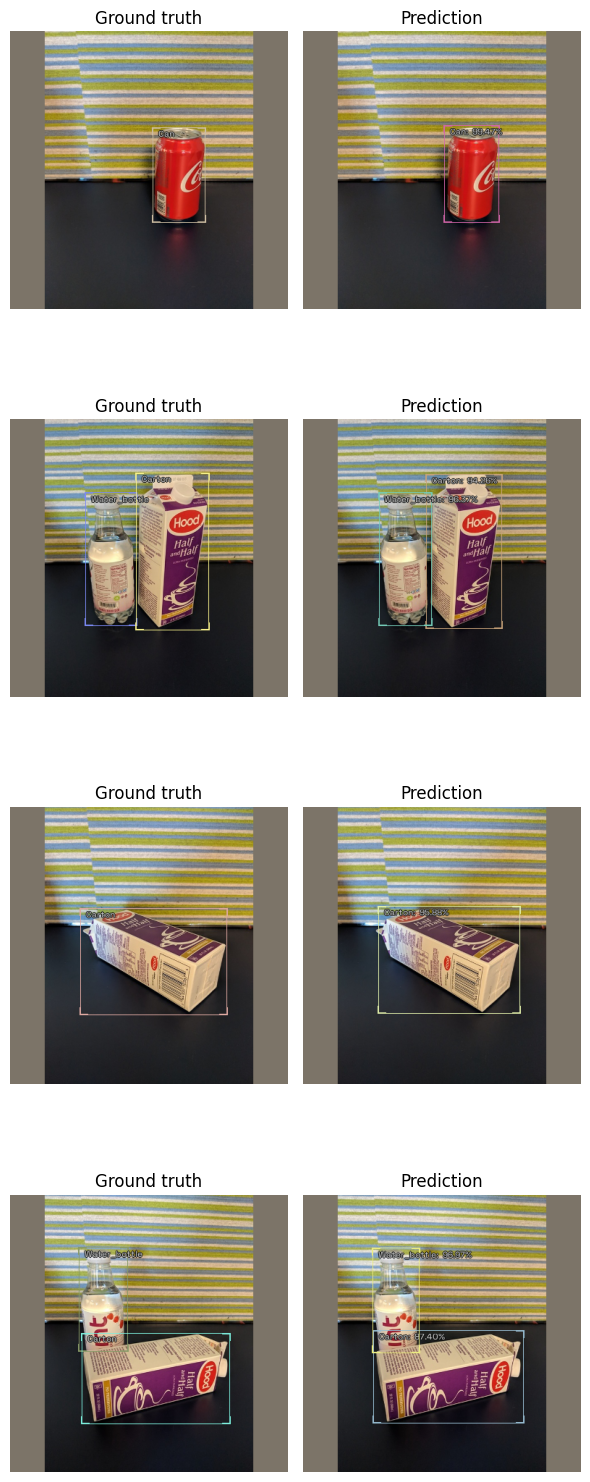

In [22]:
show_preds(preds=preds[:4])

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).